# Examples on Common LA Operations

The goal of this section is to show useful examples of common functionality such as: linear solves, eigendecomposition, SVD and trace estimation.
You can find other linear algebra operations on our [high-level API](https://cola.readthedocs.io/en/latest/package/cola.linalg.html) guide.

In [1]:
import cola
import numpy as np
from matplotlib import pyplot as plt
from jax import numpy as jnp
from jax.random import PRNGKey
from jax.random import normal
from jax.random import split

## Linear Solves

Given a square linear operator $A$ and a rhs vector $b$ we want to find $x$ such that $Ax=b$.
We'll start by showing you how to use `CoLA`'s high-level interface to get $x$.
For this we'll generate a small example ($N=100$) on `JAX` using two utility functions `generate_spectrum` and `generate_pd_from_diag`. Both functions allow me to generate a PSD operator $A$ where its eigenvalues behave in the following manner.

In [2]:
from cola.utils_test import generate_spectrum
from cola.utils_test import generate_pd_from_diag

N = 100
dtype = jnp.float32
key = PRNGKey(seed=21)
diag = generate_spectrum(coeff=0.5, scale=1.0, size=N, dtype=np.float32)
A = jnp.array(generate_pd_from_diag(diag, dtype=diag.dtype), dtype=dtype)
key = split(key, num=1)
rhs = normal(key, shape=(N,))
rhs /= jnp.linalg.norm(rhs)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


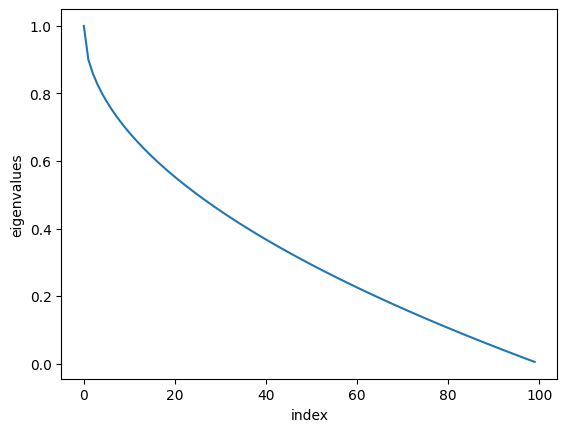

In [3]:
plt.figure()
plt.plot(diag)
plt.ylabel("eigenvalues")
plt.xlabel("index")
plt.show()

To start using `CoLA` we'll first transform $A$ into a `LinearOperator` as follows

In [4]:
A_op = cola.ops.Dense(A)

In this case we are using a `Dense` operator as we are given the dense representation of $A$. However, if we are given an `matvec` function instead, you can use the base `LinearOperator` class shown [here](https://cola.readthedocs.io/en/latest/package/cola.linear_operators.html).

In [5]:
soln = cola.inverse(A_op) @ rhs
soln_jax = jnp.linalg.solve(A, rhs)
abs_diff = jnp.linalg.norm(soln - soln_jax)
print(f"{abs_diff:1.2e}")

8.65e-06


In this case `cola.inverse(A)` represents the linear operator $A^{-1}$ that, when applied to a vector $b$, it solves the linear system $A x = b$ and then outputs $x$.
It does not, however, compute the inverse densely $A^{-1}$ and then multiply it by the vector $b$.

As you can see, in the high-level interface `CoLA` determines for the user not only what algorithm to run, given the problem and present strucutre, but it also has a set of hyperparameter default for these algorithms that work well in practice.
Thus, the user can only focus on expressing what they want to do.

Yet, in some instances a user might want to run a specific algorithm.
For this case, the user can select an appropriate solver from the following set of [algorithms](https://cola.readthedocs.io/en/latest/package/cola.algorithms.html).
For example, if in the above problem the user wanted to use conjugate gradients (CG),
then they could run

In [6]:
from cola.algorithms import cg

soln, info = cg(A_op, rhs, tol=1e-6, max_iters=100)
soln_jax = jnp.linalg.solve(A, rhs)
abs_diff = jnp.linalg.norm(soln - soln_jax)
print(f"{abs_diff:1.2e}")
print(f"CG took {info['iterations']:,d} iterations")

1.87e-05
CG took 61 iterations


A key difference now is that the algorithm not only outputs a solution but also information `info` specific about the algorithm and the run such as the number of iterations that the algorithm took or the evolution of the residual through each iteration.

Or if the user want to use GMRES they could run the following.

In [7]:
from cola.algorithms import gmres

soln, _ = gmres(A_op, rhs, tol=1e-6, max_iters=100)
soln_jax = jnp.linalg.solve(A, rhs)
abs_diff = jnp.linalg.norm(soln - soln_jax)
print(f"{abs_diff:1.2e}")

8.94e-03


## Eigendecomposition

Another popular linear algebra operation is to find the eigenvalues and eigenvectors of a given linear operator $A$. That is, find $V$ and $\Lambda$ such that $A = V \Lambda V^*$.
To show how to do this in `CoLA` I'll generate again a PSD example but now use `PyTorch` instead.

In [8]:
from cola import PSD
import torch

N = 100
dtype = torch.float64
diag = generate_spectrum(coeff=0.5, scale=1.0, size=N, dtype=np.float64)
A = torch.tensor(generate_pd_from_diag(diag, dtype=diag.dtype), dtype=dtype)
A_op = PSD(cola.ops.Dense(A))
diag = torch.tensor(diag)

eig_vals, eig_vecs = cola.eig(A_op)
eig_vals, _ = torch.sort(eig_vals, descending=True)
abs_diff = torch.linalg.norm(diag - eig_vals)
print(f"{abs_diff:1.2e}")

1.43e-15


Nevertheless, when $A$ is quite large we cannot afford the time or memory for a full decomposition. We could thus use an iterative eigenvalue algorithm such as power iteration (if we only want the maximum eigenvalue), Lanczos (if we have a symmetric operator) or Arnoldi (which works in general). Let's see how to run all of those options.
So to compute the maximum eigenvalue we could run

In [9]:
eig_max = cola.eigmax(A_op)
abs_diff = torch.linalg.norm(diag[0] - eig_max)
print(f"Max eigenvalue: {diag[0]:2.5f}")
print(f"Max eigenvalue estimate: {eig_max.item():2.5f}")
print(f"{abs_diff:1.2e}")

Max eigenvalue: 1.00000
Max eigenvalue estimate: 1.00000
3.80e-07


Indeed we recover the largest eigenvalue. The algorithm that `CoLA` ran in this case was the power method. But since in this example $A$ is symmetric we could use Lanczos and we can do so as follows

In [10]:
eig_vals, eig_vecs = cola.eig(A_op, method="lanczos")
eig_vals, _ = torch.sort(eig_vals, descending=True)
abs_diff = torch.linalg.norm(diag - eig_vals)
print(f"{abs_diff:1.2e}")

1.15e-15


Finally, we could run the workhorse algorithm from large and general linear operators: Arnoldi. In this case, I'll show how to run this algorithm using the low-level algorithmic interface in `CoLA`

In [11]:
eig_vals, eig_vecs, _ = cola.algorithms.arnoldi_eig(A_op, max_iters=60)
eig_vals, _ = torch.sort(eig_vals, descending=True)
abs_diff = torch.linalg.norm(diag[:10] - eig_vals[:10])
print(f"{abs_diff:1.2e}")

3.74e-10


/home/ubu/cola/cola/torch_fns.py:140: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:278.)
  return array.to(dtype)


In the previous example I passed `max_iters` as Arnoldi is usually ran for much less than the size of the problem. As you can see from the difference, this general algorithm is able to recover the top 10 eigenvalues to numerical precision.
Moreover, the estimates of the other values are fairly close to the target value (although not to a high precision).

In [12]:
print(diag[:30])
print(eig_vals[:30])

tensor([1.0000, 0.9000, 0.8586, 0.8268, 0.8000, 0.7764, 0.7551, 0.7354, 0.7172,
        0.7000, 0.6838, 0.6683, 0.6536, 0.6394, 0.6258, 0.6127, 0.6000, 0.5877,
        0.5757, 0.5641, 0.5528, 0.5417, 0.5310, 0.5204, 0.5101, 0.5000, 0.4901,
        0.4804, 0.4708, 0.4615], dtype=torch.float64)
tensor([1.0000, 0.9000, 0.8586, 0.8268, 0.8000, 0.7764, 0.7551, 0.7354, 0.7172,
        0.7000, 0.6838, 0.6683, 0.6536, 0.6394, 0.6258, 0.6127, 0.6000, 0.5829,
        0.5755, 0.5632, 0.5405, 0.5307, 0.5058, 0.4967, 0.4749, 0.4570, 0.4422,
        0.4282, 0.4019, 0.3896], dtype=torch.float64)


## Singular Value Decomposition (SVD)

## Trace Estimation